In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state

In [2]:
def standardize(X,y):
    # Standardize X to have mean = 0 std = 1
    # Standardize y to have mean = 0
    X_scaled = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    y_scaled = y-np.mean(y)
    return X_scaled, y_scaled


def plot_coefficients(beta,alpha,alpha_opt=10,name=None):
    # Plotting regression coefficients vs lambda
    beta_opt = beta[:,np.argmin(np.abs(alpha-alpha_opt))]
    plt.figure()
    plt.plot(np.log10(alpha),beta.T,'-')
    plt.plot(np.log10(alpha_opt)*np.array([1,1]), [np.min(beta), np.max(beta)], 'k--')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\beta$')
    plt.title(name)
    plt.show()

def plot_CV_MSE(alpha_vals, mse, alpha_opt, name=None):
    mse_mean = np.mean(mse,axis=1)
    mse_std = np.std(mse,axis=1)
    plt.figure()
    plt.errorbar(np.log10(alpha_vals), mse_mean, mse_std)
    plt.plot(np.log10([alpha_opt,alpha_opt]), [0,np.max(mse)],'k--')
    plt.xlabel(r'log($\lambda$)')
    plt.ylabel('MSE')
    plt.title(name)
    plt.show()
    print('Optimal value of lambda is: ', np.round(alpha_opt,3))
        

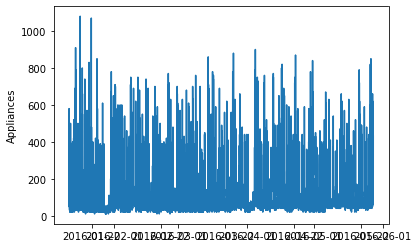

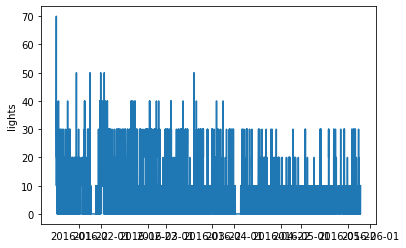

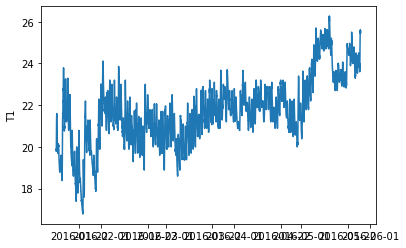

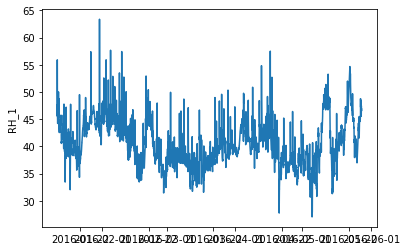

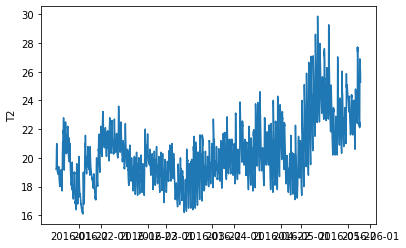

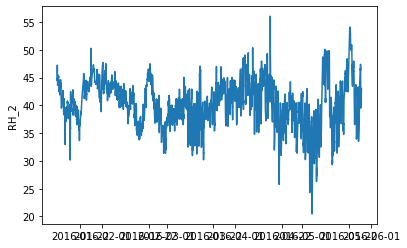

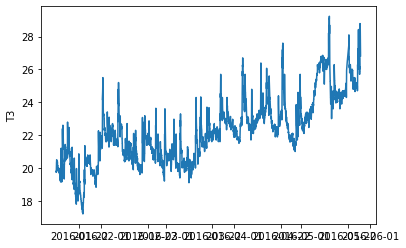

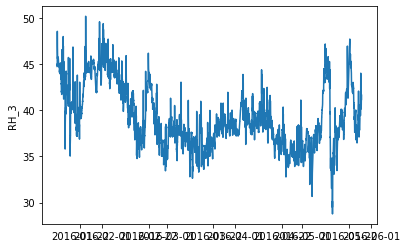

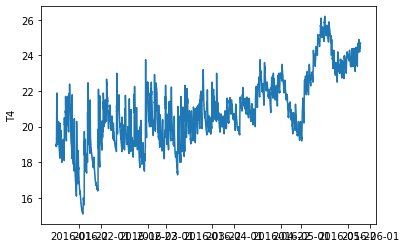

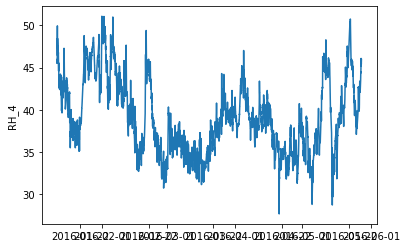

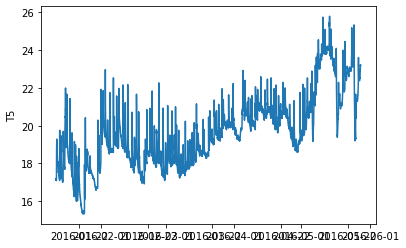

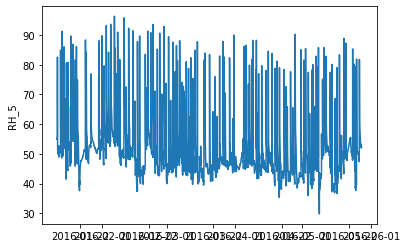

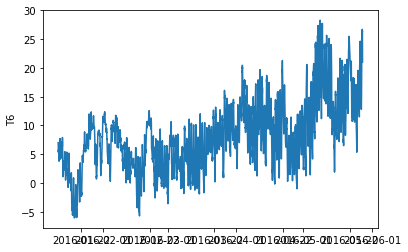

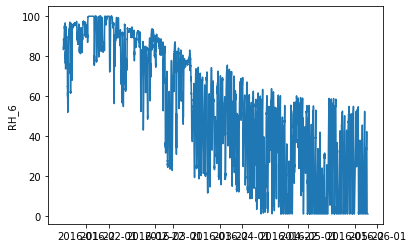

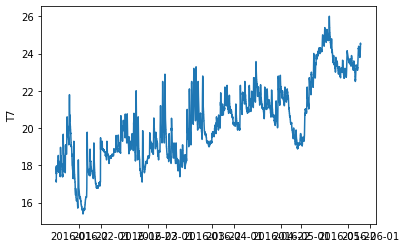

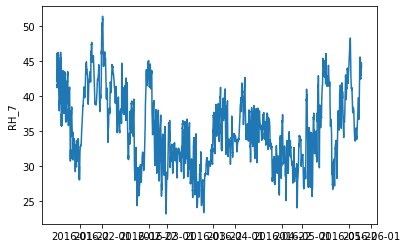

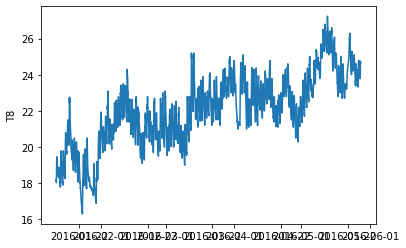

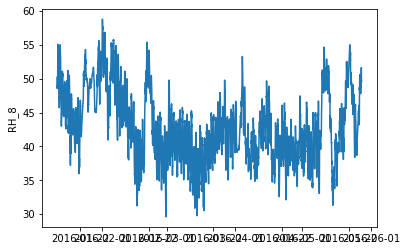

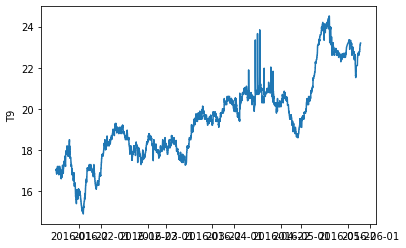

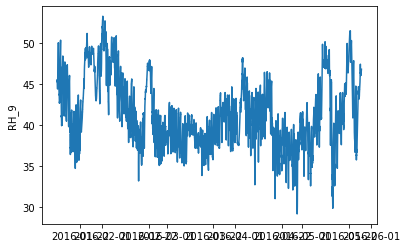

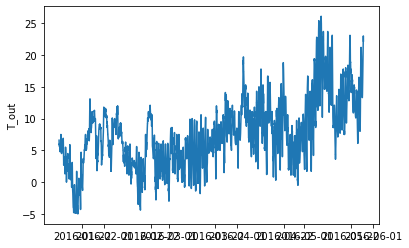

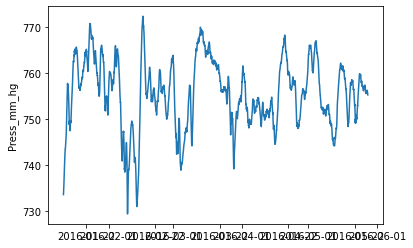

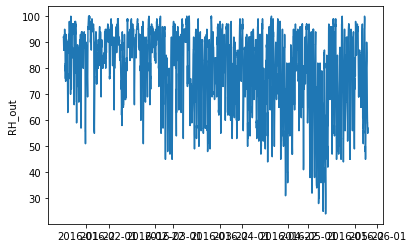

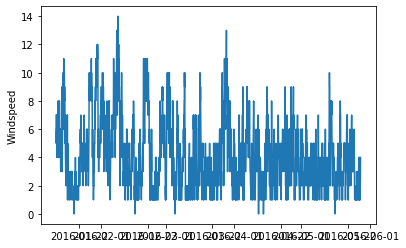

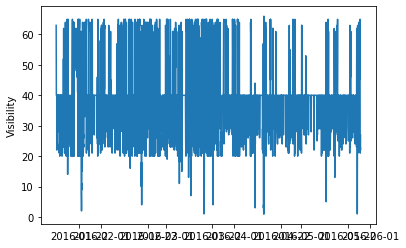

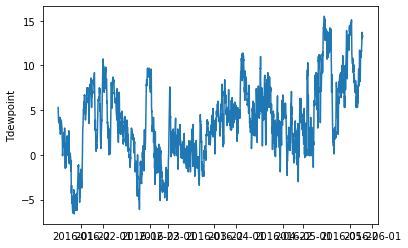

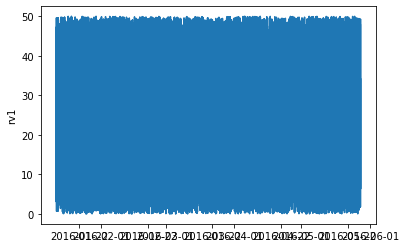

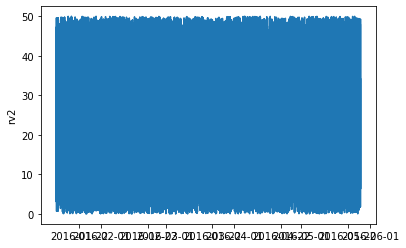

In [3]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

for i in range(len(df.columns)):
    plt.figure()
    plt.plot(df[df.columns[i]])
    plt.ylabel(df.columns[i])
    plt.show()

### Taking an n-hour mean

In [4]:
df = df.resample('24h').mean()

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [5]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i in range(len(df)):
    weekday[i] = df.index[i].weekday() 
    weekstatus[i] = weekday[i] >= 5 # False for workday, True for weekend
    NSM[i] = (df.index[i] - df.index[i].replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = df.index[i].month
df['weekday'] = weekday
df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month

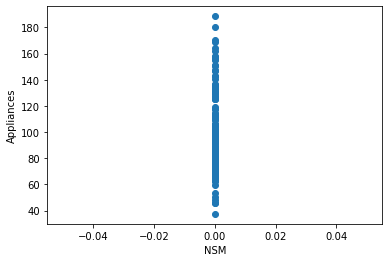

In [6]:
plt.figure()
plt.scatter(df['NSM'],df['Appliances'])
plt.xlabel('NSM')
plt.ylabel('Appliances')
plt.show()

### Filtering data and making training set
Example: Only february, after 16:00 and workday

In [7]:
#df_train = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]
df_train = df[(df.index.month==2)]
df_train = df_train.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

# Training data
y = np.array(df_train['Appliances']).reshape(-1,1)
X = np.array(df_train[df_train.columns[1:]])
X, y = standardize(X,y)

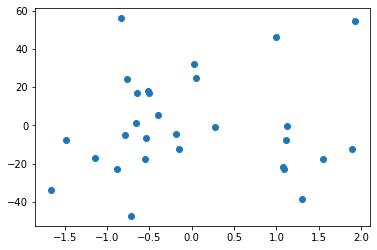

In [8]:
plt.figure()
plt.scatter(X[:,19],y)
plt.show()

### Cross validation

In [9]:
# Creating array of penalties

n_alpha = 100 # Number of penalties
min_alpha = .01 # min penalty
max_alpha = 100 # Maximum penalty
alpha_vals = np.logspace(np.log10(min_alpha),np.log10(max_alpha),n_alpha)
alpha_vals = alpha_vals[::-1] # reversing array (some sklearn standard?)

#### CV Lasso

In [10]:
cv_lasso = linear_model.LassoCV(cv=10, max_iter=10000, random_state=0, fit_intercept=False, alphas=alpha_vals).fit(X, y)

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.575209185652284, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.709399772452798, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_mode

#### CV Ridge

In [11]:
cv_ridge = linear_model.ElasticNetCV(cv=10, max_iter=10000, random_state=0, l1_ratio=0, fit_intercept=False, alphas=alpha_vals).fit(X, y)

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7344.802993631877, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7341.575408490702, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_mod

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7015.948674919827, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6985.318981178208, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6952.445320442557, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5187.387848042446, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5081.326304099883, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4973.791527636089, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2391.4132791779275, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2308.5505570966916, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227.9490793107643, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8593.289529556789, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8579.480720669482, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8564.846911519764, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7887.939359039758, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7844.234406603459, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7798.538616163129, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5819.761296608364, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5712.553969575732, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5604.636168541529, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3116.860380628711, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3035.2711210716584, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2955.339287833973, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/py

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7925.777576601739, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7915.286212020058, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7903.9536046795465, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pytho

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7179.270584996139, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7121.70898243279, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7061.553098098247, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4963.695554753378, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4869.952513347298, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4776.490667649625, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2774.8046453457528, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2703.003938273766, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2631.8393658524965, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyth

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9123.671877251734, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9095.406930087764, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9065.250631342515, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7366.751203492958, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7254.446640872624, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7139.357825595461, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4136.090922932364, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4035.5031200176477, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3937.306315189271, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/py

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9435.121231916186, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9428.336677562835, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9421.002619416015, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8912.42006006689, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8870.525839023872, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8826.050673632051, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyth

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6822.778355858709, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6707.390422475455, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6591.224340063117, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4012.6916576009526, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3920.067120888464, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3828.5623828380503, tolerance: 1.9023074560111786
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/p

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8820.1895732445, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8812.255958260266, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8803.595744401991, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pytho

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8081.714773547617, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8018.808601492132, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7952.262011916519, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5398.398663872542, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5287.260650138898, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5177.489513681673, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2769.8865937405135, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2679.541331373625, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2589.7079843806864, tolerance: 1.7808288680482158
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/p

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9059.576978251725, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9031.69319730372, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9002.017768044272, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7381.485206193402, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7275.097374950692, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7166.247659361041, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4501.317384008649, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4417.272424814135, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4334.999400115697, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2638.008081482567, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2571.9097010172077, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2505.9884416542454, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8910.864822010732, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8881.892794191901, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8851.013169018563, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7307.751550001791, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7207.820180638258, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7105.851224846167, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4451.444335023738, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4352.052068545961, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4253.053136671178, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9112.457835712888, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9105.193593634582, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9097.336778401905, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8548.77477968989, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8504.104965709656, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8456.86030637042, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pytho

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6368.996875552493, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6260.024712857631, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6150.847404455018, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3668.462283092481, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3579.389114796881, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3490.7509093232948, tolerance: 1.8388130335175643
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/py

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6779.074587736556, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6764.615908413035, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6749.17692916491, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyth

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5370.510256456888, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5289.679380653938, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5206.787712030167, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2657.6210531786032, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2591.4562027858146, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525.9158005951817, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/

#### CV Elastic net (0.5 ratio)

In [12]:
cv_elnet = linear_model.ElasticNetCV(cv=10, random_state=0, max_iter=10000, l1_ratio=0.5, fit_intercept=False, alphas=alpha_vals).fit(X, y)

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [13]:
print('Lasso score: ', cv_lasso.score(X,y))
print('Ridge score: ', cv_ridge.score(X,y))
print('Elastic net score: ', cv_elnet.score(X,y))

Lasso score:  0.643034011278087
Ridge score:  0.5814605360566554
Elastic net score:  0.5140421348610489


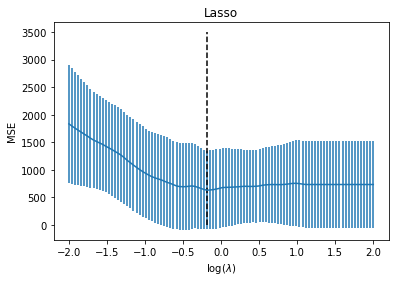

Optimal value of lambda is:  0.658


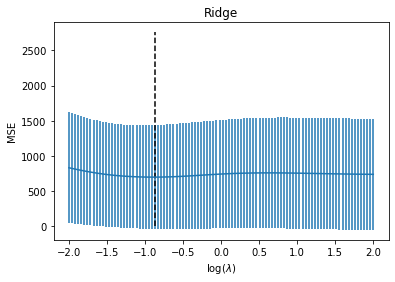

Optimal value of lambda is:  0.135


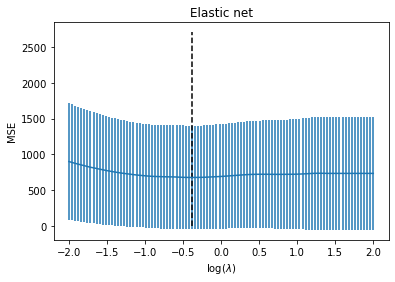

Optimal value of lambda is:  0.413


In [14]:
plot_CV_MSE(alpha_vals,cv_lasso.mse_path_,cv_lasso.alpha_, 'Lasso')
plot_CV_MSE(alpha_vals,cv_ridge.mse_path_,cv_ridge.alpha_, 'Ridge')
plot_CV_MSE(alpha_vals,cv_elnet.mse_path_,cv_elnet.alpha_, 'Elastic net')

### Lasso

In [15]:
beta_lasso = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = linear_model.Lasso(alpha=alpha_vals[i], max_iter = 10000, fit_intercept = False)
    reg.fit(X,y)
    beta_lasso[:,i] = reg.coef_

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3405310460125293, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(


### Ridge

In [16]:
beta_ridge = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = linear_model.ElasticNet(alpha=alpha_vals[i], max_iter = 10000, l1_ratio=0, fit_intercept = False)
    reg.fit(X,y)
    beta_ridge[:,i] = reg.coef_

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9607.930662242881, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9602.741972930857, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9597.11041040267, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyth

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9210.294937991916, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9176.604066797907, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9140.710474662685, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7265.350568774877, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7152.263686968829, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7037.644696668037, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/pyt

/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4385.041619630361, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4289.354532297386, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4194.8753989157285, tolerance: 1.9329633620689657
  model = cd_fast.enet_coordinate_descent(
/home/sander/miniconda3/envs/mn8701/lib/py

### Elastic net

In [17]:
beta_elnet = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = linear_model.ElasticNet(alpha=alpha_vals[i], max_iter=10000, l1_ratio=0.5, fit_intercept = False)
    reg.fit(X,y)
    beta_elnet[:,i] = reg.coef_

### Grouped Lasso
Does not work yet

(-1, 'lights') (1, 'T1') (1, 'RH_1') (2, 'T2') (2, 'RH_2') (3, 'T3') (3, 'RH_3') (4, 'T4') (4, 'RH_4') (5, 'T5') (5, 'RH_5') (6, 'T6') (6, 'RH_6') (7, 'T7') (7, 'RH_7') (8, 'T8') (8, 'RH_8') (9, 'T9') (9, 'RH_9') (10, 'T_out') (10, 'Press_mm_hg') (10, 'RH_out') (10, 'Windspeed') (10, 'Visibility') (10, 'Tdewpoint') (-1, 'rv1') (-1, 'rv2')


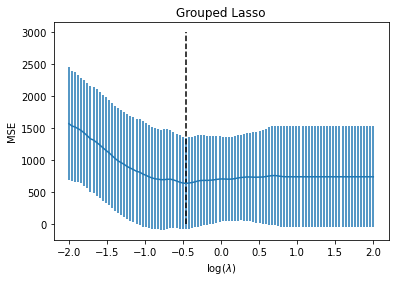

Optimal value of lambda is:  0.343


In [28]:
from sklearn.model_selection import cross_val_score
beta_glasso = np.zeros((X.shape[1],n_alpha))
#group_keys= {"T":-1,
#            "RH":-1,
#            "":-1}
group_keys= {"T":1,
            "RH":2,
            "":-1}

groups = []
for var_name in df_train.columns[1:]:
    for key, value in group_keys.items():
        if key in var_name:
            groups.append(value)
            break
# Group the rooms, and outside together
groups=[-1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, -1, -1]
print(*zip(groups, df_train.columns[1:]))
cv_outs = []
min_cv = np.inf
group_reg = 0.05
for i in range(n_alpha):
    reg = GroupLasso(
    groups=groups,
    group_reg=group_reg*alpha_vals[i],#alpha_vals[i],
    l1_reg=(1-group_reg)*alpha_vals[i],
    frobenius_lipschitz=True,
    #scale_reg="inverse_group_size",
    #scale_reg="inverse_group_size",
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )
    cv_out = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_outs.append(cv_out)
    reg.fit(X, y)
    beta_glasso[:,i] = reg.coef_.reshape(-1,)
    #print(f"mean {cv_out.mean()}, stdev {cv_out.std()}")
    if -cv_out.mean() < min_cv:
        min_cv = -cv_out.mean()
        gl_min_alpha = alpha_vals[i]
plot_CV_MSE(alpha_vals, -np.array(cv_outs), gl_min_alpha, 'Grouped Lasso')

### Plotting coefficients vs lambda

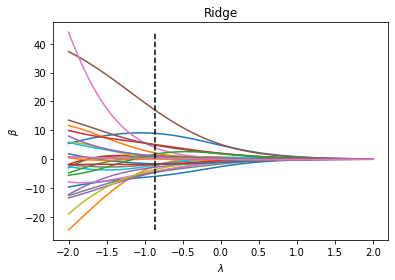

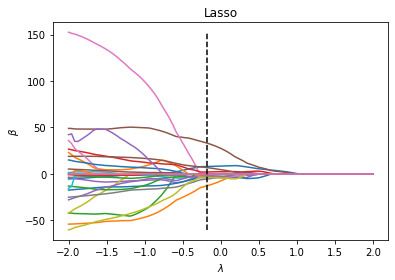

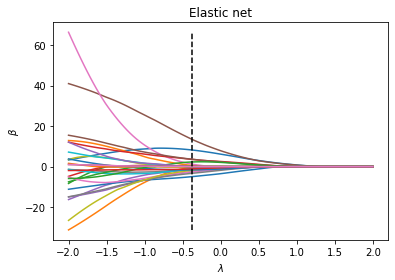

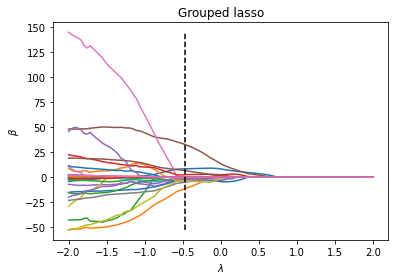

In [29]:
plot_coefficients(beta_ridge, alpha_vals, cv_ridge.alpha_, name='Ridge')
plot_coefficients(beta_lasso, alpha_vals, cv_lasso.alpha_, name='Lasso')
plot_coefficients(beta_elnet, alpha_vals, cv_elnet.alpha_, name='Elastic net')
plot_coefficients(beta_glasso,alpha_vals, gl_min_alpha,name='Grouped lasso')

In [30]:
data = {'Feature': list(df_train.columns[1:])}
df_results = pd.DataFrame(data)
df_results['Lasso'] = beta_lasso[:,alpha_vals==cv_lasso.alpha_]
df_results['Ridge'] = beta_ridge[:,alpha_vals==cv_ridge.alpha_]
df_results['Elastic net'] = beta_elnet[:,alpha_vals==cv_elnet.alpha_]
df_results['Grouped Lasso'] = beta_glasso[:,alpha_vals==gl_min_alpha]
df_results

,Feature,Lasso,Ridge,Elastic net,Grouped Lasso
0,lights,8.015377,8.968021,8.244349,8.237002
1,T1,-12.777056,-2.421738,-0.195598,-11.323814
2,RH_1,-0.000000,0.536322,0.000000,-0.000000
3,T2,-0.000000,1.190021,0.089832,-0.000000
4,RH_2,-1.978006,-2.801881,-1.692045,-1.808061
5,T3,33.238377,17.114000,13.589429,32.296925
6,RH_3,0.000000,4.072997,1.293192,0.000000
7,T4,-3.899298,-1.747808,-1.211990,-3.973371
8,RH_4,-0.000000,0.307880,-0.000000,-0.000000
9,T5,-0.619641,-2.091211,-1.032950,-1.059710


### Testing with another month

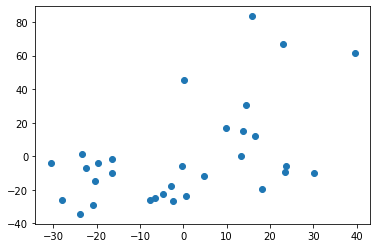

0.643034011278087
0.25518803339239315


In [21]:
#df_test = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]
df_test = df[(df.index.month==3)]
df_test = df_test.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

# Testing data
y_t = np.array(df_test['Appliances']).reshape(-1,1)
X_t = np.array(df_test[df_test.columns[1:]])
X_t, y_t = standardize(X_t,y_t)

reg = linear_model.ElasticNet(alpha=cv_elnet.alpha_, max_iter = 1000, l1_ratio=0.5, fit_intercept = False)
reg = linear_model.Lasso(alpha=cv_lasso.alpha_, max_iter = 1000, fit_intercept = False)
reg.fit(X,y)
y_p = reg.predict(X_t)

plt.figure()
plt.scatter(y_p,y_t)
plt.show()
print(reg.score(X,y))
print(reg.score(X_t,y_t))